# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Combined work

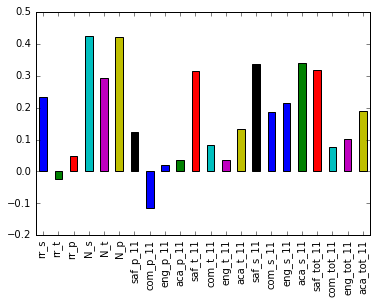

In [19]:
%matplotlib inline
import matplotlib.pyplot as plot
combined.corr()["sat_score"][survey_fields].plot.bar()

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.
It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.
How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.
The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

Correlation: 0.3376387443608813


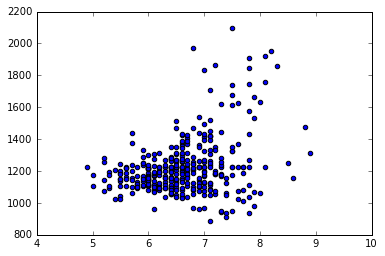

In [20]:
saf_s_11 = combined['saf_s_11']
sat_score = combined['sat_score']

plot.scatter(saf_s_11, sat_score)
print("Correlation: " + str(saf_s_11.corr(sat_score)))

SAT scores has positive correlation with the scores about safety

#Map

In [21]:
district = combined.groupby('school_dist').agg(numpy.mean)
district.reset_index(inplace=True)

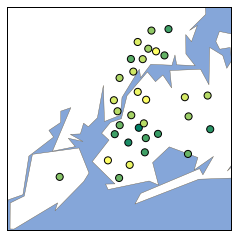

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
# Temporary bug: if you run the following line of code in the Jupyter Guided Project interface on Dataquest, you'll get an error. 
# We're working on a fix, thanks for your patience! This should work fine locally on your own computer though.
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = district["lon"].tolist()
latitudes = district["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=district["saf_s_11"], cmap="summer")

t looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

In [23]:
races = ['white_per','asian_per','black_per','hispanic_per']

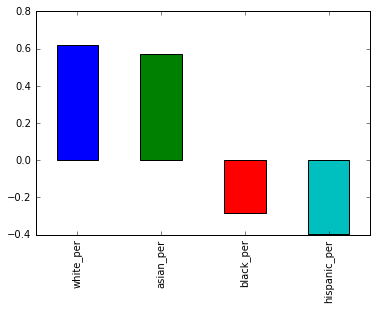

In [24]:
combined.corr()['sat_score'][races].plot.bar()

It looks like white an asian gets the highest score

NameError: name 'hispanic_per' is not defined

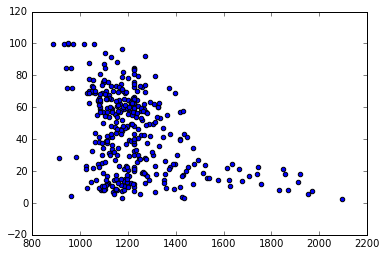

In [25]:
plot.scatter(combined['sat_score'], combined['hispanic_per'])
hispanic_mean = combined['sat_score'][hispanic_per].mean()
print("Mean value " + str(hispanic_mean))

In [ ]:
lower_hispanic_grade = combined[combined['hispanic_per'] > 95]
lower_hispanic_grade.head()

In [ ]:
high_hispanic_grade = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
high_hispanic_grade.head(15)

# Female vs Male

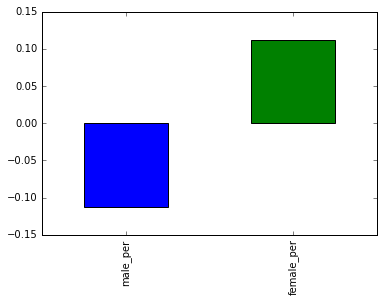

In [27]:
gender = ['male_per', 'female_per']

combined.corr()['sat_score'][gender].plot.bar()

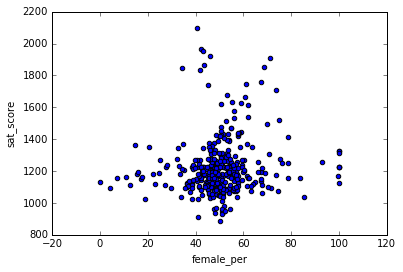

In [29]:
combined.plot.scatter('female_per', 'sat_score')

In [30]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [32]:
ap_per = combined['AP Test Takers '] / combined['total_enrollment']

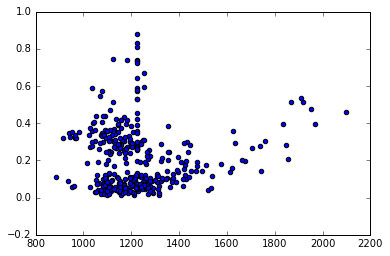

In [34]:
plot.scatter(combined['sat_score'], ap_per)

In [35]:
print("Correlation: " + str(combined['sat_score'].corr(ap_per)))

Correlation: 0.05717081390766968
